# Mercado Inmobiliario

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils as Utils
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.metrics import mean_squared_error
#Use this to see available styles
#plt.style.available

plt.style.use('fivethirtyeight')

## 1. Análisis Exploratorio de Datos

Lectura del dataset:

In [9]:
data=pd.read_csv('DS_Proyecto_01_Datos_Properati.csv', parse_dates=[0])

### Primeras 3 filas ###

In [10]:
data.head(3)

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta


### Tamaño del dataset: ###

In [11]:
data.shape

(146660, 19)

### Renombrando las columnas l2 y l3

Las columnas "l2" y "l3" se usaran frecuentemente para analisis graficos, por lo tanto es mejor recordar su significado.

In [16]:
data.rename(columns={'l2':'region', 'l3':'neighborhood'}, inplace=True)

### Valores faltantes: ###

Total de valores faltantes por cada columna:

In [17]:
data.isna().sum()

start_date             0
end_date               0
created_on             0
lat                 9925
lon                 9959
l1                     0
region                 0
neighborhood           0
rooms                  0
bedrooms               0
bathrooms           5957
surface_total      20527
surface_covered    21614
price                  0
currency               0
title                  0
description            0
property_type          0
operation_type         0
dtype: int64

### Tipos de propiedad: ###

Tipos de propiedad y cantidad de instancias por cada una

In [18]:
propertyTypes=data['property_type'].value_counts()
print('Tipos de propiedad: ', propertyTypes, sep='\n\n')

Tipos de propiedad: 

Departamento       107326
Casa                21521
PH                  14298
Lote                 1312
Oficina               658
Otro                  374
Local comercial       325
Casa de campo         322
Depósito              265
Cochera               259
Name: property_type, dtype: int64


Explorando tipos de propiedad:

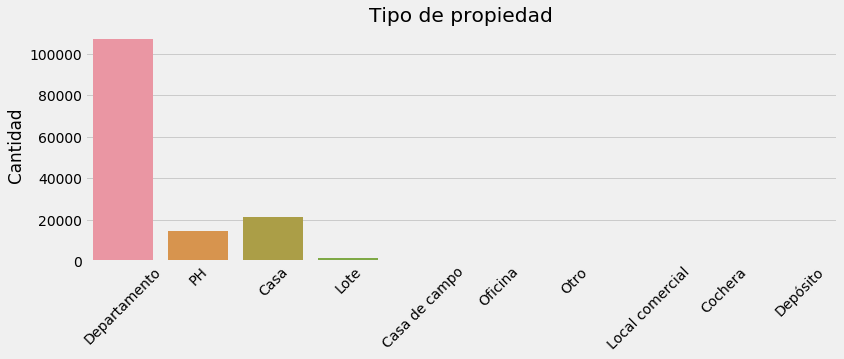

In [7]:
plt.figure(figsize=(12,4))
Utils.generate_barplot(data, 'property_type', 'Tipo de propiedad')
plt.savefig('images/tipos_propiedad.png', optimize=True)

Explorando regiones y barrios:

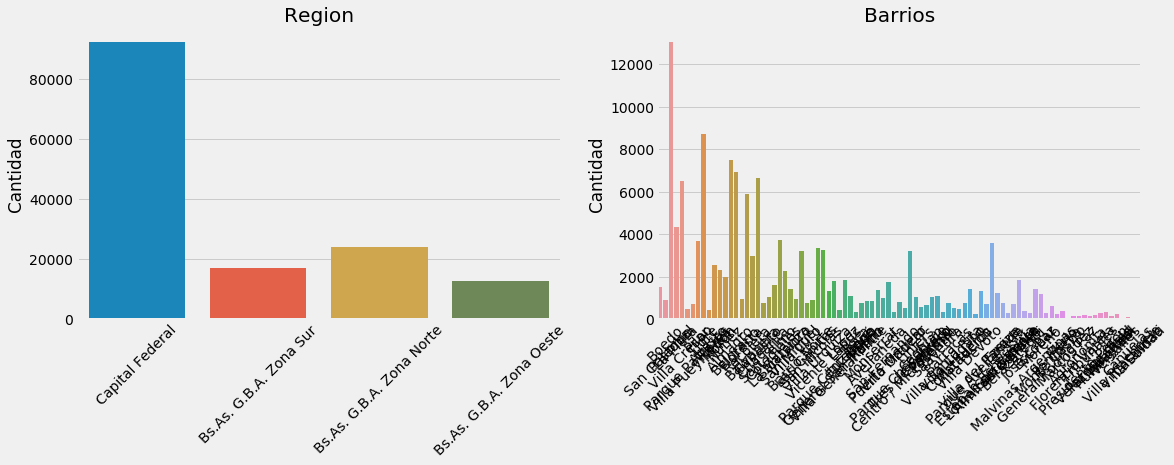

In [7]:
plt.figure(figsize=(17,5))
plt.subplot(1,2,1)
Utils.generate_barplot(data, 'l2', 'Region')
plt.subplot(1,2,2)
Utils.generate_barplot(data, 'l3', 'Barrios')
plt.savefig('images/regios_barrios.png')
plt.show()


#### Opcional: Segmentacion del diagrama de barras para la columna barrios. ####

Se ha creado la function **split_barplot()** para graficar diagramas de barras para columnas con numerosas categorias para poder distinguirlas en el eje X.

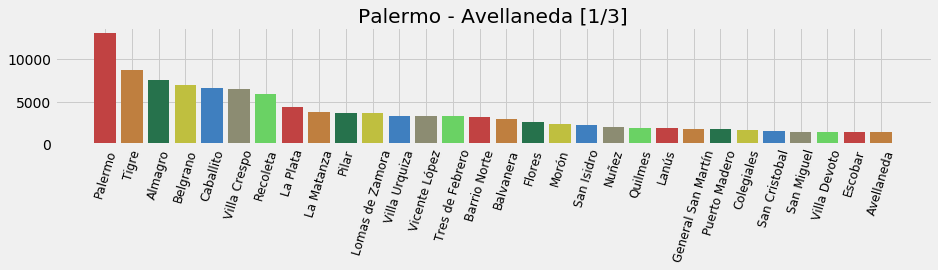

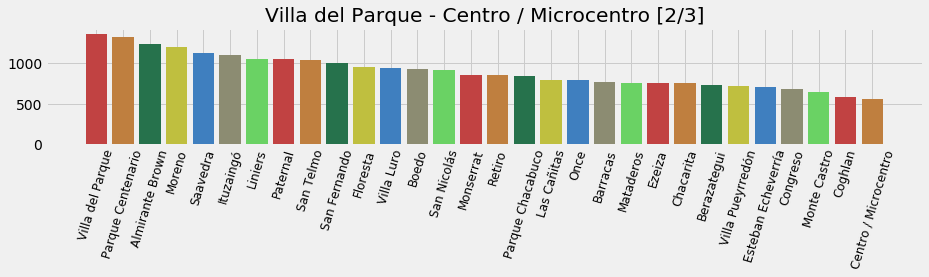

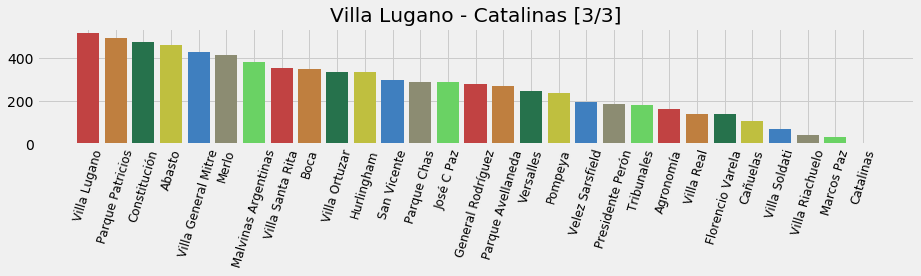

In [37]:
Utils.split_barplot('l3', data, 3)

In [8]:
maxPropertyTypes=propertyTypes.keys()[:3]
print('-> Propiedas con mas publicaciones: {}\n'.format(maxPropertyTypes))

maxRegion=data['l2'].value_counts().keys()[0]
print('-> Region con mas publicaciones: {}\n'.format(maxRegion))

-> Propiedas con mas publicaciones: Index(['Departamento', 'Casa', 'PH'], dtype='object')

-> Region con mas publicaciones: Capital Federal



__<font color='red'>NOTA: Ejecutar esta celda para restablecer los valores del dataframe "data_filtered"</font>__

Se ejecutara el primer filtro en un nuevo dataframe que se utilizara en las proximas celdas:

In [10]:
with pd.enable()
dataFiltered=data[data['property_type'].isin(maxPropertyTypes) & (data['l2'] == maxRegion) ]
print('-> Nuevas dimensiones: ', dataFiltered.shape)

SyntaxError: invalid syntax (<ipython-input-10-450781e4a9e2>, line 1)

## 2. Distribuciones y relaciones de a pares:

### Se crea una lista para contener las variables:

In [40]:
variables=['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price', 'property_type']

### Obteniendo medidas descriptivas y de dispersión:

In [42]:
dataFiltered[variables].describe()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,91485.000000,91485.000000,89314.000000,82568.000000,82250.000000,9.148500e+04
mean,2.964278,1.960278,1.560147,112.626369,94.966310,2.595003e+05
std,1.314704,1.072946,0.860309,980.713664,778.515243,3.222654e+05
min,1.000000,0.000000,1.000000,10.000000,1.000000,6.000000e+03
25%,2.000000,1.000000,1.000000,49.000000,44.000000,1.200000e+05
50%,3.000000,2.000000,1.000000,71.000000,63.000000,1.750000e+05
75%,4.000000,3.000000,2.000000,111.000000,96.000000,2.790000e+05
max,26.000000,15.000000,14.000000,126062.000000,126062.000000,3.243423e+07


### Ajustando rango de valores para la variable 'surface_total' del dataframe

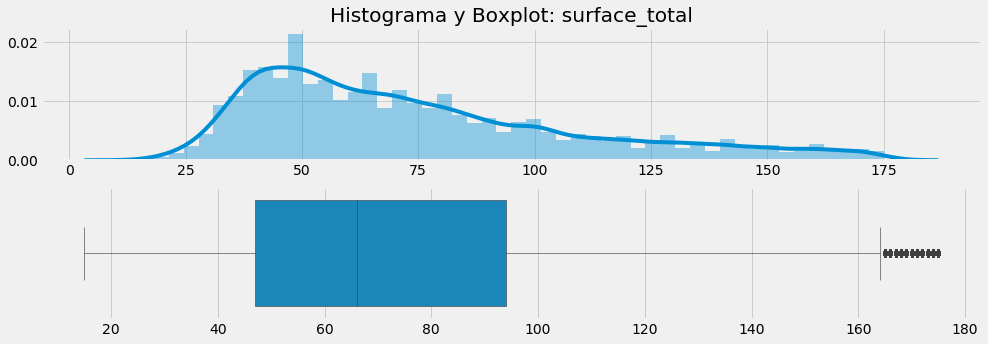

In [47]:
MIN_SURF, MAX_SURF = 15, 175
Utils.plot_distribution(column_name='surface_total', min_pivot=MIN_SURF, max_pivot=MAX_SURF, dataframe=dataFiltered)
plt.savefig('images/hist1.png')

Se ajusto un rango de superficies total de entre **15** y **1000** m2

In [48]:
dataFiltered = dataFiltered.query(f'{MIN_SURF} <= surface_total <=  {MAX_SURF}')
print('-> Nuevas dimensiones: ', dataFiltered.shape)

-> Nuevas dimensiones:  (73800, 19)


### Filtrando dataframe con superficies cubiertas menores o igual a la superficie total

In [50]:
dataFiltered=dataFiltered.query('surface_covered < surface_total')
print('-> Nuevas dimensiones: ', dataFiltered.shape)

-> Nuevas dimensiones:  (50188, 19)


### Ajustando rango de valores para la variable 'price' del dataframe

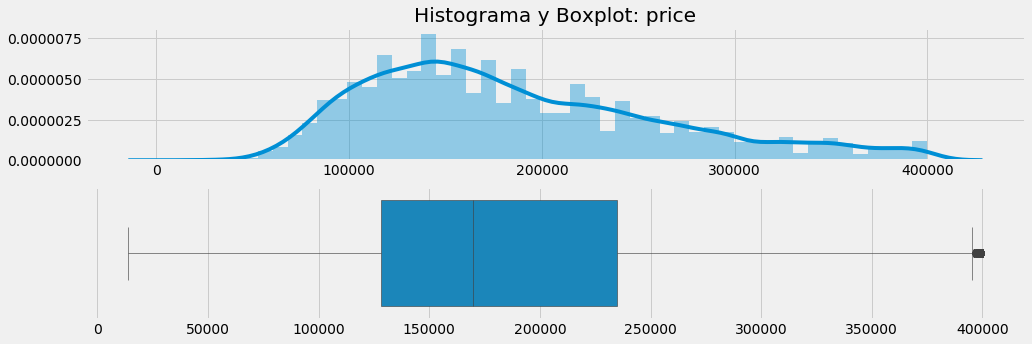

In [56]:
MIN_PRICE, MAX_PRICE = 0, 400000
Utils.plot_distribution(column_name='price', max_pivot=MAX_PRICE, dataframe=dataFiltered)
plt.savefig('images/hisprice.png')

De acuerdo al analisis del grafico boxplot en conjunto con el histograma, se decidio filtrar aquellos valores menores a **48000** para obtener una mejor distribucion.

In [57]:
dataFiltered = dataFiltered.query(f'{MIN_PRICE} <= price <=  {MAX_PRICE}')
print('-> Nuevas dimensiones: ', dataFiltered.shape)

-> Nuevas dimensiones:  (46615, 19)


### Eliminando instancias faltantes

Seleccionamos los siguientes atributos del dataframe antes de eliminar los valores faltantes:

In [58]:
dataFiltered=dataFiltered[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price','l2', 'l3', 'start_date','property_type' ]]
print('-> Nuevas dimensiones: ', dataFiltered.shape)

-> Nuevas dimensiones:  (46615, 10)


Explorando valores faltandes con las columnas que se han elegido:

In [59]:
dataFiltered.isna().sum()

rooms                0
bedrooms             0
bathrooms          428
surface_total        0
surface_covered      0
price                0
l2                   0
l3                   0
start_date           0
property_type        0
dtype: int64

Las unicas columnas que presentan valores faltantes son **"bathrooms"** y **"surface_covered"**. En el siguiente paso se obtendra un dataframe sin estos valores:

In [60]:
dataFiltered.dropna(inplace=True)
print('-> Nuevas dimensiones: ', dataFiltered.shape)

-> Nuevas dimensiones:  (46187, 10)


### Evolución Precio vs Periodo

A continuación se genera un diagrama para observar la relación del precio conforme avanza el tiempo, el eje X corresponde a periodos mensuales desde Enero de 2019 hasta Enero de 2020 y en el eje Y, el promedio del precio en tal período.

Asi se calcula el período utilizando la columna **"start_date"** del dataframe filtrado.

In [61]:
dataFiltered['period']=dataFiltered['start_date'].dt.to_period('M').astype('str')

Se creó la siguiente función para generar un lineplot de Seaborn, su único parámetro corresponde al dataframe:

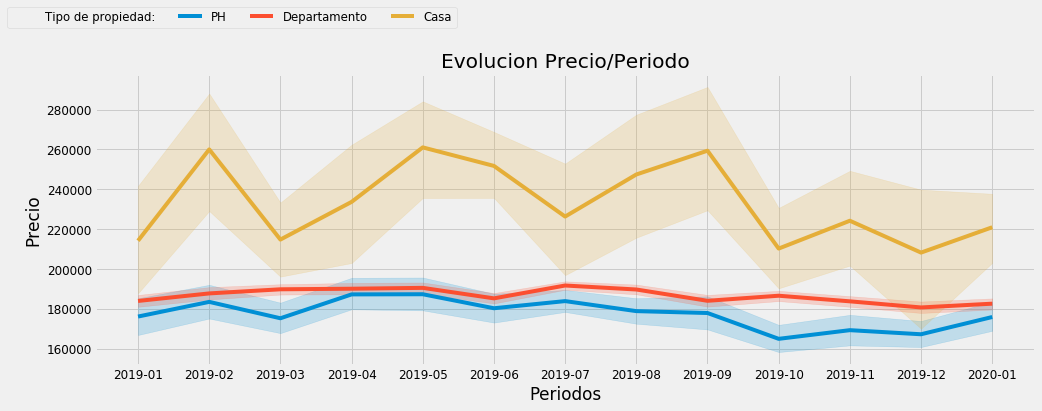

In [62]:
Utils.plot_price_by_period(dataFiltered)
plt.savefig('images/priceperiodo.png')

Se eliminan las columnas del dataframe para continuar con los próximos análisis:

In [63]:
print('Antes: ', dataFiltered.columns)
#Obteniendo diferencia de columnas.
colsDrop=set(dataFiltered.columns)-set(variables)
if set(colsDrop).issubset(dataFiltered.columns):
    dataFiltered.drop(columns=colsDrop, inplace=True)
print('Despues: ', dataFiltered.columns)

Antes:  Index(['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered',
       'price', 'l2', 'l3', 'start_date', 'property_type', 'period'],
      dtype='object')
Despues:  Index(['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered',
       'price', 'property_type'],
      dtype='object')


### Correlaciones:

Generando graficos de dispersion e histograma para cada par de variable utiliando:

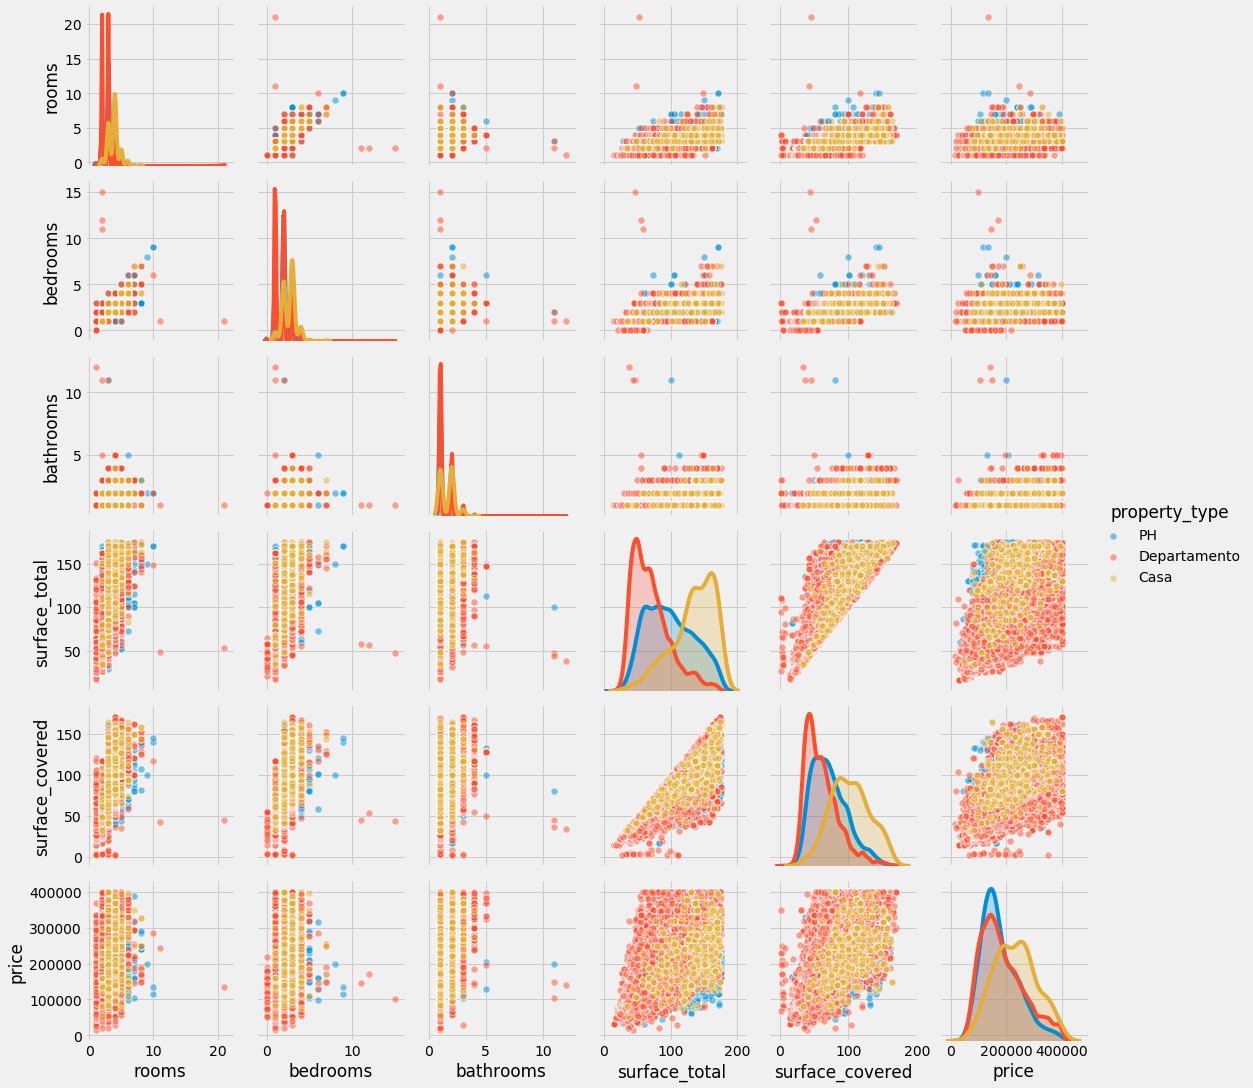

In [64]:
sns.pairplot(dataFiltered, hue='property_type', plot_kws=dict(s=50, linewidth=1, alpha=.5))

Generando mapa de correlaciones **Pearson** y **Spearman** en (Formato Heatmap) para cada par de variable del dataframe:

La función **plot_heatmaps()** fué creada para ese propósito:

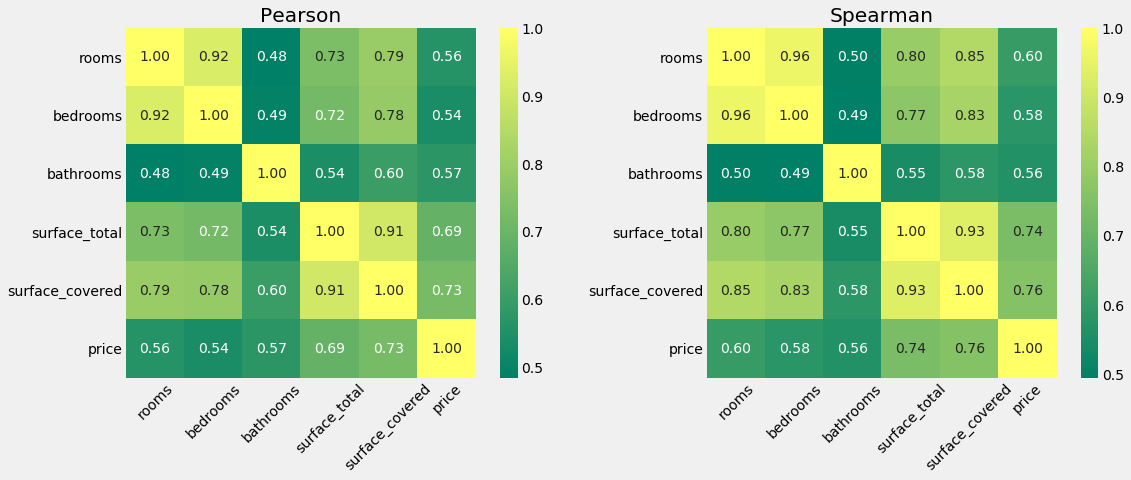

In [65]:
Utils.plot_heatmaps(dataFiltered)

**Pearson:** Existe alta correlacion entre la variable "*price*" con la **superficie total** con un valor de 0.69 y el **numero de baños** con un valor de 0.64, por lo tanto, podrian ser las variables regresoras con mayor influencia a la hora de de entrenar el modelo, y "*surface_covered*" con menor influencia.

**Spearman:** Existe alta correlacion entre la variable "*price*" con la **superficie total** y **cubierta** con un valor de 0.84 para ambas, por lo tanto, podrian ser las variables regresoras con mayor influencia a la hora de de entrenar el modelo, y "*bedrooms*" con menor influencia.

## 3. Machine Learning

En esta sección, debes entrenar dos modelos de Machine Learning - uno de vecinos más cercanos y otro de árboles de decisión -  para predecir el precio de las propiedades tipo `Departamento`, `PH` y `Casa`  en la Ciudad Autónoma de Buenos Aires (`Capital Federal`). Para ello, no debes olvidarte de:

* Elegir una métrica apropiada para evaluar los resultados de los modelos.
* Seleccionar las variables predictoras (`X`) y la variable a predecir (`y`). 
* Realizar un Train/Test split de los datos.
* Generar un modelo *benchmark* y evaluarlo.
* Entrenar un modelo de vecinos más cercanos y un modelo de árbol de decisión con hiperparámetros iniciales de su elección.
* Evaluar los modelos obtenidos. Para ello, evalúa la métrica elegida en el conjunto de Test y en el conjunto de Train. También, realiza gráficos de valores reales vs. valores predichos.
* Mejorar el desempeño de sus modelos optimizando el número de vecinos y la profundidad del árbol, respectivamente.
* Entre los modelos entrenados, ¿cuál elegirías para utilizar?¿Por qué? 
* Ser **crítico/a** con la metodología utilizada. Por ejemplo, responde las siguientes preguntas: ¿Qué información no estás usando que podría ayudar al modelo?¿Qué información puede estar demás o repetida?

In [66]:
X=dataFiltered[variables[:5]]
y=dataFiltered[['price']]

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=42)

In [68]:
dataFiltered.shape, X_train.shape, X_test.shape

((46187, 7), (32330, 5), (13857, 5))

### Modelo inicial

In [69]:
initialModelTree, initialModelKnn = DecisionTreeRegressor(max_depth=3, random_state=42), KNeighborsRegressor(n_neighbors=5)

In [70]:
initialModelTree.fit(X_train, y_train)
initialModelKnn.fit(X_train, y_train)

KNeighborsRegressor()

Modelo: Árbol de Decisión
Raíz del error cuadrático medio en Train: 51512.55074574962
Raíz del error cuadrático medio en Test: 51181.50132013465


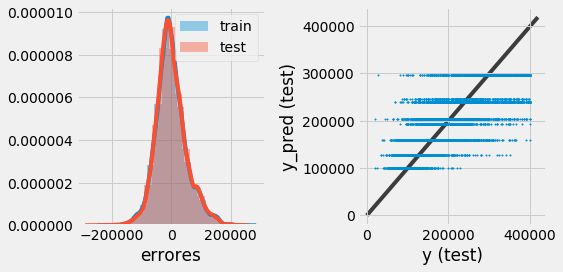

Modelo: Vecinos más cercanos
Raíz del error cuadrático medio en Train: 39164.19276472928
Raíz del error cuadrático medio en Test: 44603.3727297617


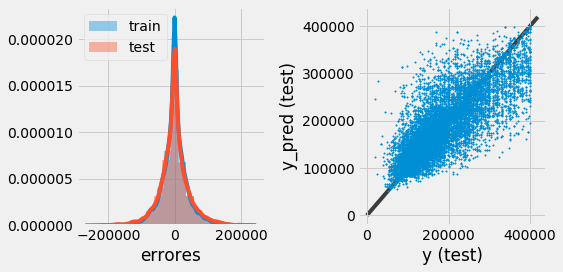

In [71]:
modelos = ['Árbol de Decisión', 'Vecinos más cercanos']

for i, model in enumerate([initialModelTree, initialModelKnn]):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test=np.array(y_test).reshape(-1,1)
    y_train= np.array(y_train).reshape(-1,1)
    y_train_pred=np.array(y_train_pred).reshape(-1,1)
    y_test_pred=np.array(y_test_pred).reshape(-1,1)
    
    print(f'Modelo: {modelos[i]}')

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')
    
    plt.figure(figsize = (8,4))

    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2)
    
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    
    plt.tight_layout()
    plt.show()

#### Curva de validacion

In [72]:
degree = np.arange(1, 21, 1)

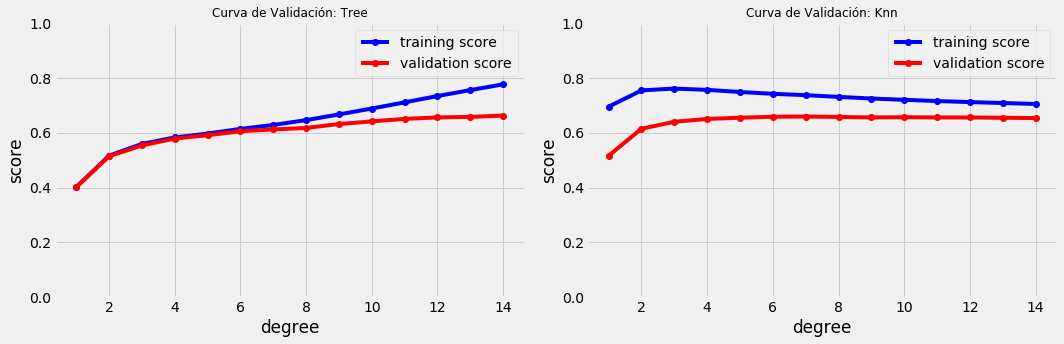

In [73]:
arange =  np.arange(1,15,1)
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
Utils.plot_validation_curve('tree', X, y, arange)
plt.subplot(1,2,2)
Utils.plot_validation_curve('knn', X, y, arange)
plt.tight_layout()

#### Curva de Errores

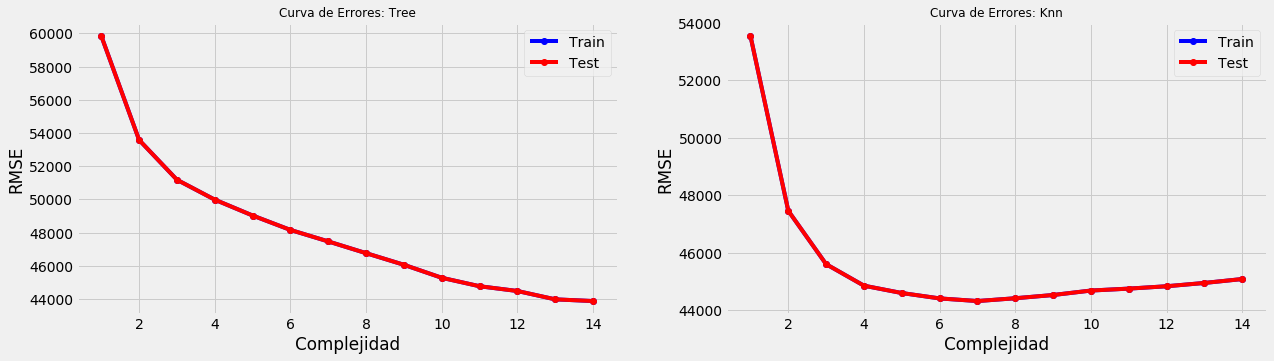

In [74]:
plt.figure(figsize = (19,5))
plt.subplot(1,2,1)
Utils.plot_rmse_curve('tree',
                      X_train = X_train, 
                      X_test  = X_test, 
                      y_train = y_train, 
                      y_test  = y_test, 
                      k_values= arange)
plt.subplot(1,2,2)
Utils.plot_rmse_curve('knn', 
                      X_train = X_train, 
                      X_test  = X_test, 
                      y_train = y_train, 
                      y_test  = y_test, 
                      k_values= arange)

Hi, we are here para ho